In [ ]:
'''
Alec K. Mattu
INST 414
07/03/2021

Project 3
'''

In [128]:
# Import the needed libraries
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
import nltk
import string
import json
import math
import requests
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import text
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import linear_model
from nltk.corpus import stopwords
from bs4 import BeautifulSoup as bs

# Part 0A
## Pre-processing of songs dataset

In [108]:
# Variable for songs
songs = []

# Open CSV and read each row into songs variable
with open('dataset_output.csv') as cvf:
    reader = csv.DictReader(cvf)
    for row in reader:
        # Add song to lyrics list
        songs.append(row)

# Part 0B
## Add "favorite song" to dataset

In [109]:
# Fetch Lyric Page
song = {
    "song title": "Taro",
    "artist/band name": "alt-J",
    "year": 2012,
    "lyrics url": "https://www.azlyrics.com/lyrics/altj/taro.html"
}
page = requests.get(song["lyrics url"])

# Validate the lyric request
if (page.status_code != 200):
    print("Failed to download song lyrics")
    exit()

# Parse the HTML content from the request
soup = bs(page.content, "html.parser")

# Find the lyrics div
lyric_div = soup.find(class_= "col-xs-12 col-lg-8 text-center").find("div", attrs = {'class': None})   

# Strip HTML from the lyrics div
lyrics = lyric_div.text.splitlines()

# Remove null entries from dict
lyrics = list(filter(None, lyrics))

# Recombine the lyrics into a single string
song["lyrics"] = str.join("\n", lyrics)

# Add favorite song to song list
songs.append(song)

# Part 0C
## Convert songs to DataFrame

In [110]:
# Define ignored words
ignored = sorted(stopwords.words("english"))
ignored.append("'s")
ignored.append("'m")
ignored.append("!")
ignored.append("!!")

# Iterate through songs list
for row in songs:
    # Tokenize lyrics
    tokenized = nltk.word_tokenize(row["lyrics"])
    no_stopwords = [w for w in tokenized if w not in ignored]
    row["lyrics_split"] = [w for w in no_stopwords if w not in string.punctuation]
    row["lyrics_split"] = [w for w in row["lyrics_split"] if not str.isnumeric(w)]

    # Take tokenized words, strip non-unique instances, count word frequencies
    freqdist = nltk.FreqDist(row["lyrics_split"])
    row["lyrics_split_frequencies"] = dict((word, freq) for word, freq in freqdist.items() if not word.isdigit())

In [111]:
# Turn the songs variable into a Pandas DF
df = pd.DataFrame(songs)

In [112]:
# Force year column to integer
df["year"] = pd.to_numeric(df["year"])

In [113]:
# View head/tail of dataframe
df

,song title,artist/band name,year,lyrics url,lyrics,lyrics_split,lyrics_split_frequencies
0,Shaking The Blues Away,Doris Day,1955,https://www.azlyrics.com/lyrics/dorisday/shaki...,There's an old superstition 'way down south\nE...,"[There, old, superstition, 'way, south, Everyb...","{'There': 1, 'old': 1, 'superstition': 1, ''wa..."
1,Mood Indigo,"Sinatra, Frank",1955,https://www.azlyrics.com/lyrics/franksinatra/m...,"You ain't been blue; no, no, no\nYou ain't bee...","[You, ai, n't, blue, You, ai, n't, blue, Till,...","{'You': 2, 'ai': 2, 'n't': 2, 'blue': 3, 'Till..."
2,All Alone,Julie London,1956,https://www.azlyrics.com/lyrics/julielondon/al...,"All alone, I'm so all alone\nThere is no one e...","[All, alone, I, alone, There, one, else, All, ...","{'All': 3, 'alone': 6, 'I': 2, 'There': 1, 'on..."
3,Dolly Dawn,Harry Belafonte,1956,https://www.azlyrics.com/lyrics/harrybelafonte...,"Look, look at Dolly,\nPretty, pretty, pretty, ...","[Look, look, Dolly, Pretty, pretty, pretty, pr...","{'Look': 1, 'look': 1, 'Dolly': 8, 'Pretty': 2..."
4,You're My Thrill,"Lee, Peggy",1956,https://www.azlyrics.com/lyrics/peggylee/youre...,"You're my thrill, you do something to me\nYou ...","[You, 're, thrill, something, You, send, chill...","{'You': 2, ''re': 6, 'thrill': 6, 'something':..."
...,...,...,...,...,...,...,...
496,I Just Love You,UPPERROOM,2020,https://www.azlyrics.com/lyrics/upperroom/ijus...,I just wanna move You\nWhat moves You?\nI just...,"[I, wan, na, move, You, What, moves, You, I, w...","{'I': 65, 'wan': 8, 'na': 8, 'move': 2, 'You':..."
497,Cowgirl Blues (Mark Wystrach Vocal),Midland,2021,https://www.azlyrics.com/lyrics/midland/cowgir...,"So long, my hill country woman\nDon't cry\nBut...","[So, long, hill, country, woman, Do, n't, cry,...","{'So': 2, 'long': 2, 'hill': 2, 'country': 2, ..."
498,Lights On,"Blue Stones, The",2021,https://www.azlyrics.com/lyrics/bluestones/lig...,"I saw it from a distance, it came without a so...","[I, saw, distance, came, without, sound, I, co...","{'I': 14, 'saw': 1, 'distance': 1, 'came': 1, ..."
499,Le Couteau,Mansfield.TYA,2021,https://www.azlyrics.com/lyrics/mansfieldtya/l...,"Aime-moi, aime-toi\nNous ne sommes pas ennemis...","[Aime-moi, aime-toi, Nous, ne, sommes, pas, en...","{'Aime-moi': 1, 'aime-toi': 1, 'Nous': 2, 'ne'..."


# 1A
## Top 5 songs with consine similarity to favorite song

In [121]:
# Vectorize lyrics with CountVectorizer
bag_of_words = text.CountVectorizer(tokenizer = lambda txt: txt.split(), stop_words = "english")
docterm = bag_of_words.fit_transform(df["lyrics"])

# Add document terms to a DataFrame
document_terms = pd.DataFrame(docterm.toarray(), columns = bag_of_words.get_feature_names(), index = df["song title"])

# Normalize document terms DataFrame
document_terms_normalized = pd.DataFrame(normalize(document_terms), columns = bag_of_words.get_feature_names(), index = df["song title"])

In [127]:
# Reference "Favorite Song" Row
ref = document_terms_normalized.iloc[500]

# Pull cosine similarities to ref song
cosines = document_terms_normalized.dot(ref)

# Print top 5 closest songs to ref
# 5 is default, with a 1:1 similarity to the original song, I.E. we need the top 6
cosines.nlargest(6)

song title
Taro                                   1.000000
With You                               0.114658
Rather Be Me                           0.097293
Cowgirl Blues (Mark Wystrach Vocal)    0.095719
All I Can See                          0.094667
You Never Give Me Your Money           0.092692
dtype: float64

# 2A
## Top 5 songs using TF-IDF Vectorizer

In [163]:
# Vectorize lyrics with TF-IDF
bag_of_words = TfidfVectorizer(tokenizer = lambda txt: txt.split(), stop_words = "english")
docterm = bag_of_words.fit_transform(df["lyrics"])

# Add document terms to a DataFrame
document_terms = pd.DataFrame(docterm.toarray(), columns = bag_of_words.get_feature_names(), index = df["song title"])

# Normalize document terms DataFrame
document_terms_normalized = pd.DataFrame(normalize(document_terms), columns = bag_of_words.get_feature_names(), index = df["song title"])

In [165]:
# Reference "Favorite Song" Row
ref = document_terms_normalized.iloc[500]

# Pull cosine similarities to ref song
cosines = document_terms_normalized.dot(ref)

# Print top 5 closest songs to ref
cosines.nlargest(6)

song title
Taro                            1.000000
You Never Give Me Your Money    0.090799
With You                        0.051710
Borrowing                       0.051272
Rooftops                        0.044883
Hey You                         0.042598
dtype: float64

# Part 3
## Plot cosine similarity between favorite songs

In [180]:
# Add production year cosines DataFrame
cosines_df = cosines.to_frame().merge(df[["song title", "year"]], on = "song title", how = "left")

# Rename columns
cosines_df.columns = ["song title", "cosine_similarity", "year"]

# Force cosine_similarity column to integer
cosines_df["cosine_similarity"] = pd.to_numeric(cosines_df["cosine_similarity"])

# Preview DataFrame
cosines_df.sort_values(by = ["cosine_similarity"], ascending = False).head(6)

,song title,cosine_similarity,year
506,Taro,1.000000,2012
160,You Never Give Me Your Money,0.090799,1981
20,With You,0.051710,1960
431,Borrowing,0.051272,2015
375,Rooftops,0.044883,2010
235,Hey You,0.042598,1991


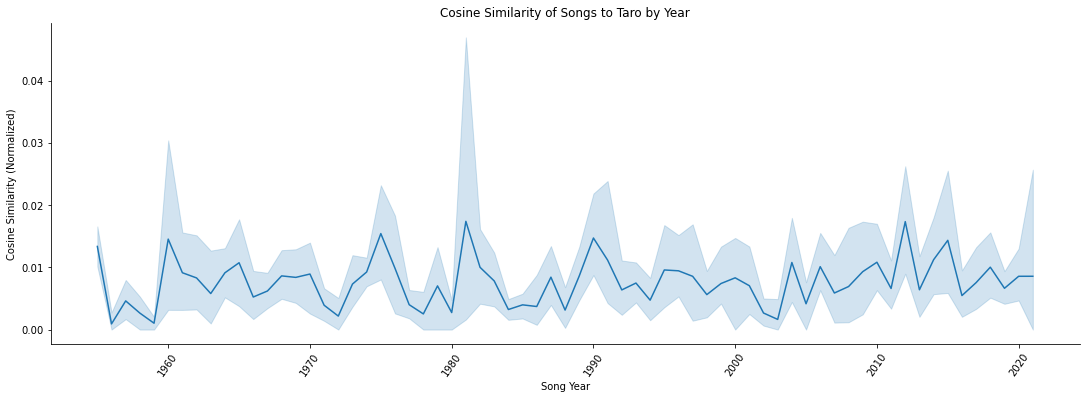

In [192]:
# Basic Rel Plot
sns.relplot(data = cosines_df[cosines_df["song title"] != "Taro"], x = "year", y = "cosine_similarity", kind = "line", aspect = 3)

# Add Rotation to X labels
locs, labels = plt.xticks()
plt.setp(labels, rotation = 55)

# Add X/Y Axis Labels
plt.title("Cosine Similarity of Songs to Taro by Year")
plt.xlabel("Song Year")
plt.ylabel("Cosine Similarity (Normalized)")

# Save plot
plt.savefig("project3_figure_117568813.pdf")

# Hide Output
None

# Part 4
## Linear Regression Analysis

In [194]:
# Linear regression values
x = cosines_df["year"].values.reshape(-1, 1)
x = np.nan_to_num(x) # Replace NaN with 0
y = cosines_df["cosine_similarity"].values.reshape(-1, 1)
y = np.nan_to_num(y) # Replace NaN with 0

# Basic linear model
model = linear_model.LinearRegression()

# Split data into training values
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.25)

# Create training model
model.fit(xtrain, ytrain)

# Show test
ypred_test = model.predict(xtest)

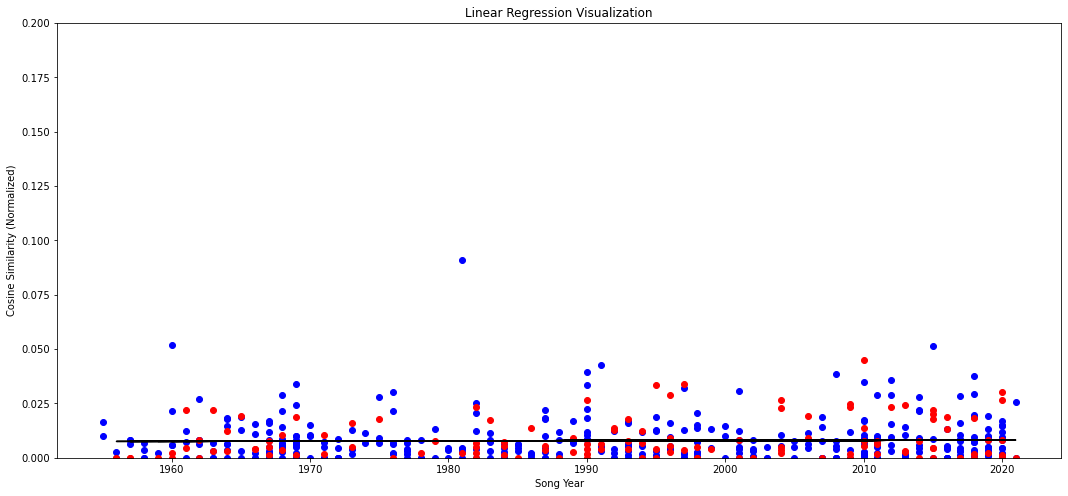

In [201]:
# Show plot
plt.figure(figsize = (18, 8))
plt.scatter(xtrain, ytrain, c = "blue") # Training data
plt.scatter(xtest, ytest, c = "red") # Testing data
plt.plot(xtest, ypred_test, c = "black")

# Add labels
plt.title("Linear Regression Visualization")
plt.xlabel("Song Year")
plt.ylabel("Cosine Similarity (Normalized)")
plt.ylim((0, 0.2))

# Hide output
None

In [202]:
mean_squared_error = metrics.mean_squared_error(ytest, ypred_test)
print("Model Mean-Squared-Error: " + str(mean_squared_error))

Model Mean-Squared-Error: 0.007832127243732492


In [207]:
r2 = metrics.r2_score(ytest, ypred_test)
print("Model R2 Score: " + str(abs(r2)))

Model R2 Score: 0.008614578406205275
